In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import shutil

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from sklearn.metrics import confusion_matrix, classification_report
from vis.visualization import visualize_cam
from vis.utils import utils

For this classification task, I am going to CNN. While I can use other methods like SVM:


1.   CNN takes care of feature extraction(and extracting good features). SVM takes the data points and tries to maximize the hyperplane between the classes in a higher dimension. So, in order to make SVM classify efficiently, I have to extract good features.

2.   CNN have the property of learning local features and then building a heirarchy of features as you go deep in the layer.

3. CNN takes care of feature invariance. If I have to use any other algorithm,I have to look at filters which will provide me feature invariance(from the dataset). So, in order to skip all the feature engineering I directly used a CNN.

In [0]:
# Training set
!wget https://www.dropbox.com/s/97f3455od3zh1pi/Train_val_Handwritten_Hindi_dataset.zip
!unzip Train_val_Handwritten_Hindi_dataset.zip
# Test set
!wget https://www.dropbox.com/s/fyk6rzkrly1z8uc/Test_Handwritten_Hindi_dataset.zip
!unzip Test_Handwritten_Hindi_dataset.zip

In [3]:
test_img = cv2.imread('Train_val/character_1_ka/1340.png')
test_img.shape

(32, 32, 3)

In [0]:
# Creating data generators for training
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dataset = 'Train_val/'
test_dataset = 'Test/'
numClasses = 5
train_classes = os.listdir(train_dataset)

In [0]:
# To rearrange the given images into appropriate folders
base_dir = 'letters'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [0]:
for i in range(numClasses):
  temp = os.path.join(train_dir, str(i + 1))
  os.mkdir(temp)
  temp = os.path.join(validation_dir, str(i + 1))
  os.mkdir(temp)
  temp = os.path.join(test_dir, str(i + 1))
  os.mkdir(temp)

In [0]:
random.seed(30)
for i in range(numClasses):
  temp = os.listdir(train_dataset + train_classes[i])
  random.shuffle(temp)
  trainSet = temp[:int(0.8*len(temp))]
  valSet = temp[int(0.8*len(temp)):]
  
  # Putting training images into a new folder
  for j in range(len(trainSet)):
    fname = '{}.{}.png'.format(str(i + 1), str(j))
    src = train_dataset + train_classes[i] + '/' + trainSet[j]
    dest = train_dir + '/' + str(i + 1) + '/' + fname
    shutil.copyfile(src, dest)
  
  # Putting validation images into a new folder
  for j in range(len(valSet)):
    fname = '{}.{}.png'.format(str(i + 1), str(j))
    src = train_dataset + train_classes[i] + '/' + valSet[j]
    dest = validation_dir + '/' + str(i + 1) + '/' + fname
    shutil.copyfile(src, dest)
  
  # Putting test images into a new folder
  temp = os.listdir(test_dataset + train_classes[i])
  for j in range(len(temp)):
    fname = '{}.{}.png'.format(str(i + 1), str(j))
    src = test_dataset + train_classes[i] + '/' + temp[j]
    dest = test_dir + '/' + str(i + 1) + '/' + fname
    shutil.copyfile(src, dest)

In [55]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(32,32),
                                                   batch_size=20,
                                                   shuffle=True,
                                                   class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(32,32),
        shuffle=True,
        batch_size=20,
        class_mode='categorical')

Found 6800 images belonging to 5 classes.
Found 1700 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


In [0]:
# Using MNIST type CNN architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
__________

In [11]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=340,
                             epochs=30,
                             validation_data = validation_generator,
                             validation_steps=85)

Epoch 1/30
340/340 [==============================] - 9s 27ms/step - loss: 0.2338 - acc: 0.9171 - val_loss: 0.0289 - val_acc: 0.9912
Epoch 2/30
340/340 [==============================] - 5s 14ms/step - loss: 0.0377 - acc: 0.9888 - val_loss: 0.0248 - val_acc: 0.9929
Epoch 3/30
340/340 [==============================] - 5s 14ms/step - loss: 0.0182 - acc: 0.9941 - val_loss: 0.0102 - val_acc: 0.9965
Epoch 4/30
340/340 [==============================] - 5s 14ms/step - loss: 0.0124 - acc: 0.9972 - val_loss: 0.0090 - val_acc: 0.9965
Epoch 5/30
340/340 [==============================] - 5s 14ms/step - loss: 0.0080 - acc: 0.9978 - val_loss: 0.0350 - val_acc: 0.9894
Epoch 6/30
340/340 [==============================] - 5s 14ms/step - loss: 0.0061 - acc: 0.9985 - val_loss: 0.0131 - val_acc: 0.9971
Epoch 7/30
340/340 [==============================] - 5s 14ms/step - loss: 0.0072 - acc: 0.9984 - val_loss: 0.0203 - val_acc: 0.9924
Epoch 8/30
340/340 [==============================] - 5s 14ms/step - 

In [0]:
#model.save('cnn1.h5')
#files.download('cnn1.h5')

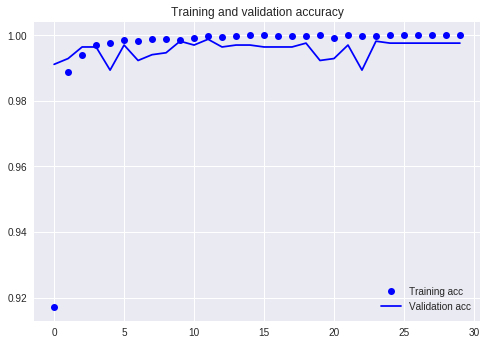

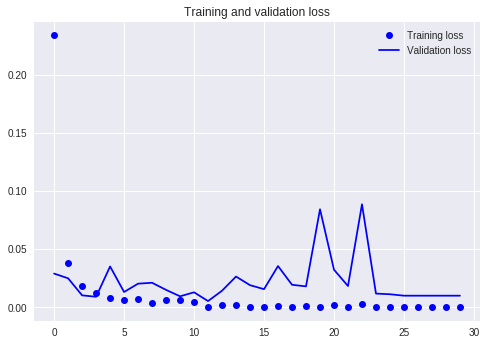

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Training accuracy vs Number of epochs
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Loss vs Number of epochs
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can use the above  analysis to choose the number of epochs(in this case, 30 seemed okay).

In [80]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(32, 32),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)
y_pred = np.argmax(predict, axis=1)

#print(model.evaluate_generator(test_generator, steps=nb_samples))

result = np.absolute(test_generator.classes-y_pred)
errorFiles = [[filenames[f], y_pred[f], predict[f]] for f in range(nb_samples) if result[f] != 0]

Found 1500 images belonging to 5 classes.
[['3/3.264.png', 0, array([9.99999881e-01, 1.38249221e-13, 1.07694184e-07, 3.41857733e-16,
       1.99912893e-21], dtype=float32)], ['5/5.201.png', 1, array([1.0860886e-31, 9.9999893e-01, 9.2640093e-17, 4.3984880e-23,
       1.0892018e-06], dtype=float32)]]


In [58]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
print(classification_report(test_generator.classes, y_pred))

Confusion Matrix
[[300   0   0   0   0]
 [  0 300   0   0   0]
 [  1   0 299   0   0]
 [  0   0   0 300   0]
 [  0   1   0   0 299]]
Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       300
          1       1.00      1.00      1.00       300
          2       1.00      1.00      1.00       300
          3       1.00      1.00      1.00       300
          4       1.00      1.00      1.00       300

avg / total       1.00      1.00      1.00      1500



I will now plot the misclassified images against a reference image and the predicted class image. I chose the first image as the reference.

As we will see below, the extra bulge and rotation in the case of the two misclassified images caused it to be incorrectly classified. To prove this point I will now use a class activation map(CAM) to see which areas get activated during prediction for each class.

In [0]:
layer_idx = utils.find_layer_idx(model, 'conv2d_3')

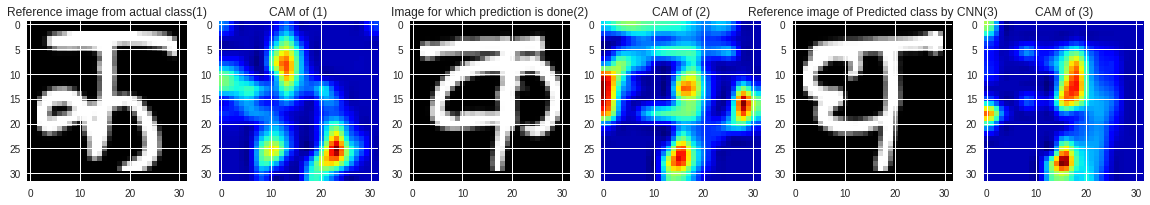

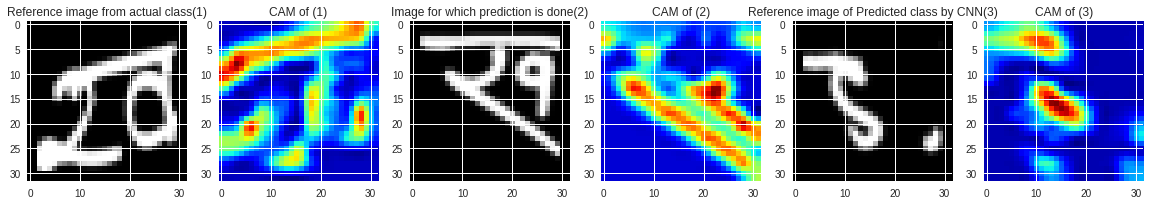

In [107]:
for i in errorFiles:
  # Setting figure parameters
  f, axarr = plt.subplots(1,6)
  f.set_figheight(20)
  f.set_figwidth(20)
  temp = cv2.imread(test_dir + '/' + i[0])
  # Print a reference image from that class
  ref_image = cv2.imread(test_dir + '/' + i[0][0] + '/' + i[0][0] + '.1.png')
  predictedClassImg = cv2.imread(test_dir + '/' + str(i[1] + 1) + '/' + str(i[1] + 1) + '.1.png')
  
  # Creating the CAM
  ref_cam = visualize_cam(model, layer_idx, filter_indices=None, seed_input=ref_image)
  given_cam = visualize_cam(model, layer_idx, filter_indices=None, seed_input=temp)
  pred_cam = visualize_cam(model, layer_idx, filter_indices=None, seed_input=predictedClassImg)
  
  # Plot
  axarr[0].imshow(ref_image)
  axarr[0].set_title('Reference image from actual class(1)')
  axarr[1].imshow(ref_cam)
  axarr[1].set_title('CAM of (1)')
  axarr[2].imshow(temp)
  axarr[2].set_title('Image for which prediction is done(2)')
  axarr[3].imshow(given_cam)
  axarr[3].set_title('CAM of (2)')
  axarr[4].imshow(predictedClassImg)
  axarr[4].set_title('Reference image of Predicted class by CNN(3)')
  axarr[5].imshow(pred_cam)
  axarr[5].set_title('CAM of (3)')

As we can see from the CAM, the part of the misclassified image which is absurd is responsible for misclassifying it to another class. The area of activation for the absurd is stronger for another class, due to which it gets misclassified.